In [1]:
from pyspark import SparkContext
from pyspark.sql import SQLContext, Row
from pyspark.sql.functions import regexp_replace, col, udf
from pyspark.sql.types import StringType
import re
import pandas as pd
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import time
from sklearn.metrics.pairwise import euclidean_distances
from mlxtend.frequent_patterns import apriori, association_rules

In [2]:
#Initialize SparkContext and SQLContext
sc = SparkContext.getOrCreate()
sqlContext = SQLContext(sc)

#Path to data file (transactionrecord.gz)
data_file = "transactionrecord.gz"

#Load the gzipped CSV file and cache it
raw_data = sc.textFile(data_file).cache()

#Extract the header (first row) from the RDD
header = raw_data.first()

#Filter out the header row and split the remaining rows by commas
csv_data = raw_data.filter(lambda row: row != header).map(lambda l: l.split(","))

#Create a list of column names based on the header
columns = header.split(",")

#Convert the csv_data into Row objects using dynamic column names
row_data = csv_data.map(lambda p: Row(**{columns[i]: p[i] for i in range(len(columns))}))

#Create a DataFrame from the RDD of Row objects
sdf = sqlContext.createDataFrame(row_data)

#Print the schema of the DataFrame
sdf.printSchema()

#Show the first 5 rows of the DataFrame
sdf.show(5)


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/09/22 12:30:56 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
/Users/jasper/Desktop/anaconda3/lib/python3.11/site-packages/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
24/09/22 12:31:02 WARN BlockManager: Task 0 already completed, not releasing lock for rdd_1_0
24/09/22 12:31:03 WARN BlockManager: Task 1 already completed, not releasing lock for rdd_1_0


root
 |-- TransactionNo: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- ProductNo: string (nullable = true)
 |-- ProductName: string (nullable = true)
 |-- Product_category: string (nullable = true)
 |-- Price: string (nullable = true)
 |-- Quantity: string (nullable = true)
 |-- CustomerNo: string (nullable = true)
 |-- Country: string (nullable = true)



24/09/22 12:31:10 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 2 (TID 2): Attempting to kill Python Worker


+-------------+---------+---------+--------------------+----------------+-----+--------+----------+--------------+
|TransactionNo|     Date|ProductNo|         ProductName|Product_category|Price|Quantity|CustomerNo|       Country|
+-------------+---------+---------+--------------------+----------------+-----+--------+----------+--------------+
|       581482|12/9/2019|    22485|Set Of 2 Wooden M...|             0ca|21.47|      12|     17490|United Kingdom|
|       581475|12/9/2019|    22596|Christmas Star Wi...|             0ca|10.65|      36|     13069|United Kingdom|
|       581475|12/9/2019|    23235|Storage Tin Vinta...|             0ca|11.53|      12|     13069|United Kingdom|
|       581475|12/9/2019|    23272|Tree T-Light Hold...|             0ca|10.65|      12|     13069|United Kingdom|
|       581475|12/9/2019|    23239|Set Of 4 Knick Kn...|             0ca|11.94|       6|     13069|United Kingdom|
+-------------+---------+---------+--------------------+----------------+-----+-

Question 1.1

In [3]:
#1.1.1
sdf = sdf.withColumn("CustomerNo", regexp_replace(col("CustomerNo"), "NA", "-1"))

In [4]:
#1.1.2
def process_text(text):
    return re.sub('[^A-Za-z]+', '', text) if text else None

#Register the UDF
process_text_udf = udf(lambda x: process_text(x), StringType())

#Apply the UDF and create a new column 'productName_process'
sdf = sdf.withColumn("productName_process", process_text_udf(col("productName")))

#Show the first 5 rows
sdf.show(5)

+-------------+---------+---------+--------------------+----------------+-----+--------+----------+--------------+--------------------+
|TransactionNo|     Date|ProductNo|         ProductName|Product_category|Price|Quantity|CustomerNo|       Country| productName_process|
+-------------+---------+---------+--------------------+----------------+-----+--------+----------+--------------+--------------------+
|       581482|12/9/2019|    22485|Set Of 2 Wooden M...|             0ca|21.47|      12|     17490|United Kingdom|SetOfWoodenMarket...|
|       581475|12/9/2019|    22596|Christmas Star Wi...|             0ca|10.65|      36|     13069|United Kingdom|ChristmasStarWish...|
|       581475|12/9/2019|    23235|Storage Tin Vinta...|             0ca|11.53|      12|     13069|United Kingdom|StorageTinVintage...|
|       581475|12/9/2019|    23272|Tree T-Light Hold...|             0ca|10.65|      12|     13069|United Kingdom|TreeTLightHolderW...|
|       581475|12/9/2019|    23239|Set Of 4 Knic

24/09/22 12:57:26 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 3 (TID 3): Attempting to kill Python Worker


Question 1.2

In [5]:
#1.2.1
df_spark = sdf.withColumn("revenue", (col("price").cast("float") * col("Quantity").cast("float")))

#Show the top 5 rows with the calculated revenue
df_spark.select("price", "Quantity", "revenue").show(5)

+-----+--------+----------+
|price|Quantity|   revenue|
+-----+--------+----------+
|21.47|      12| 257.63998|
|10.65|      36|     383.4|
|11.53|      12|    138.36|
|10.65|      12|127.799995|
|11.94|       6|     71.64|
+-----+--------+----------+
only showing top 5 rows



24/09/22 12:57:35 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 4 (TID 4): Attempting to kill Python Worker


In [6]:
#1.2.2
# Convert to Pandas DataFrame
df_pandas = df_spark.toPandas()

#Create the transaction_date column with date format based on Date column
df_pandas['transaction_date'] = pd.to_datetime(df_pandas['Date'])

#Print the top 5 rows of the Pandas DataFrame
print(df_pandas.head())

  TransactionNo       Date ProductNo                          ProductName  \
0        581482  12/9/2019     22485        Set Of 2 Wooden Market Crates   
1        581475  12/9/2019     22596  Christmas Star Wish List Chalkboard   
2        581475  12/9/2019     23235             Storage Tin Vintage Leaf   
3        581475  12/9/2019     23272    Tree T-Light Holder Willie Winkie   
4        581475  12/9/2019     23239    Set Of 4 Knick Knack Tins Poppies   

  Product_category  Price Quantity CustomerNo         Country  \
0              0ca  21.47       12      17490  United Kingdom   
1              0ca  10.65       36      13069  United Kingdom   
2              0ca  11.53       12      13069  United Kingdom   
3              0ca  10.65       12      13069  United Kingdom   
4              0ca  11.94        6      13069  United Kingdom   

               productName_process     revenue transaction_date  
0          SetOfWoodenMarketCrates  257.639984       2019-12-09  
1  ChristmasSt

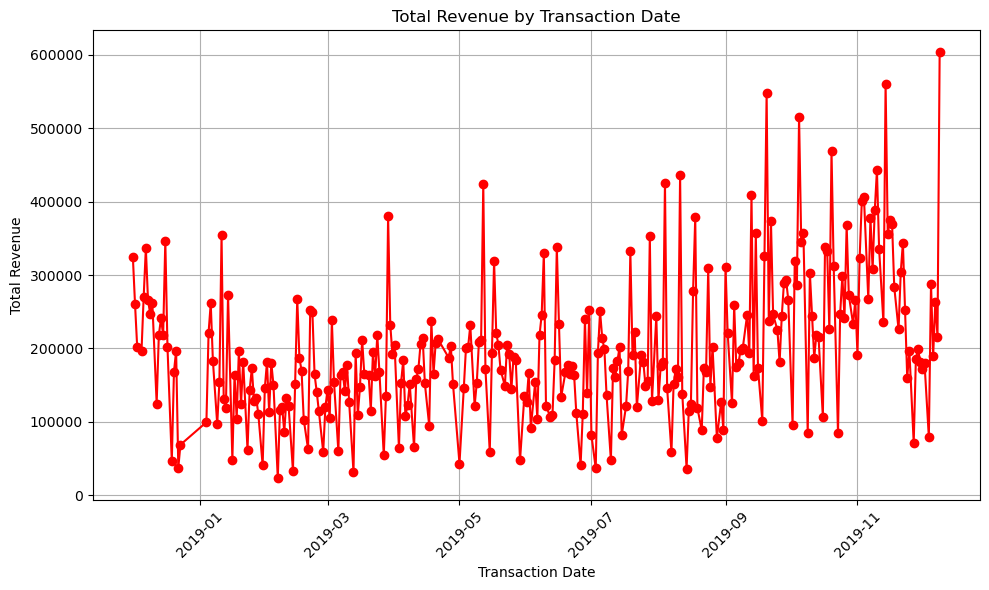

In [7]:
#1.2.3
#Group by transaction_date and calculate the sum of revenue
revenue_by_date = df_pandas.groupby('transaction_date')['revenue'].sum().reset_index()

#Plot the sum of revenue on transaction_date
plt.figure(figsize=(10, 6))
plt.plot(revenue_by_date['transaction_date'], revenue_by_date['revenue'], marker='o', linestyle='-', color='r')
plt.title('Total Revenue by Transaction Date')
plt.xlabel('Transaction Date')
plt.ylabel('Total Revenue')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


Question 1.3

  day_of_week        revenue  transaction_date
0      Monday  193362.234375                50
1   Wednesday  106041.593750                50
2    Thursday  203268.875000                47
3      Friday  223608.781250                52
4    Saturday  207174.734375                53
5      Sunday  248080.718750                53


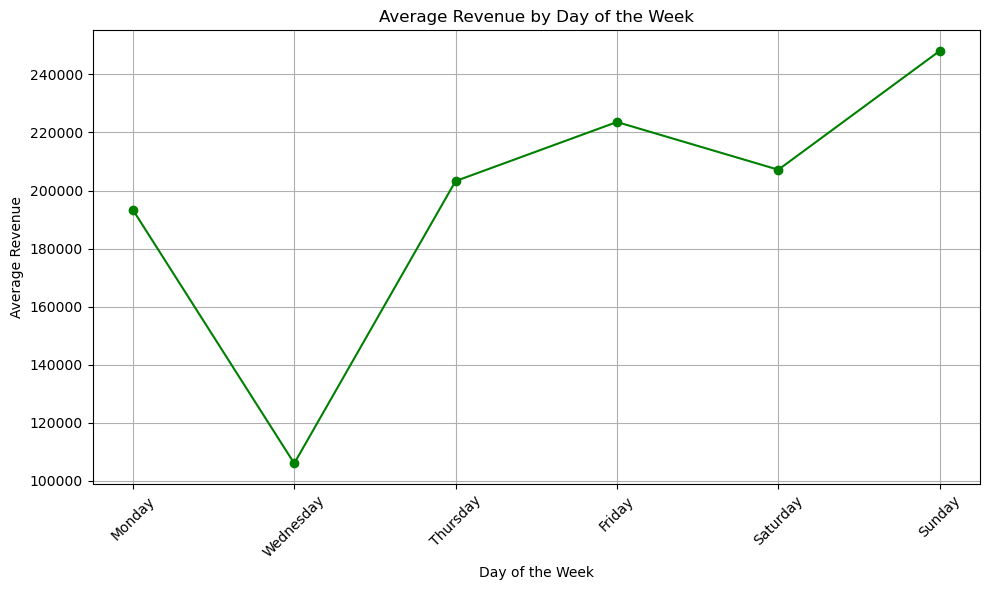

In [8]:
#1.3.1
#Ensure that transaction_date is in date format
df_pandas['transaction_date'] = pd.to_datetime(df_pandas['transaction_date'])

#Add a column for day of the week (0=Monday, 6=Sunday)
df_pandas['day_of_week'] = df_pandas['transaction_date'].dt.dayofweek

#Group by day of week and transaction date, then calculate the total revenue for each day
revenue_by_day = df_pandas.groupby(['transaction_date', 'day_of_week'])['revenue'].sum().reset_index()

#Now, group by day of the week and calculate the average revenue
#Divide the total revenue for each day of the week by the number of unique days
avg_revenue_by_day = revenue_by_day.groupby('day_of_week').agg({
    'revenue': 'mean',  # Mean revenue per unique day
    'transaction_date': 'nunique'  # Count of unique days
}).reset_index()

#Create a mapping for days of the week
days_mapping = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
avg_revenue_by_day['day_of_week'] = avg_revenue_by_day['day_of_week'].map(days_mapping)

#Print the result 
print(avg_revenue_by_day)

#Plot average revenue by day of the week
plt.figure(figsize=(10, 6))
plt.plot(avg_revenue_by_day['day_of_week'], avg_revenue_by_day['revenue'], marker='o', linestyle='-', color='g')
plt.title('Average Revenue by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Revenue')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [9]:
#Find the workday with the highest average revenue
most_profitable_day = avg_revenue_by_day.loc[avg_revenue_by_day['revenue'].idxmax(), 'day_of_week']
print(f"The workday with the highest average revenue is: {most_profitable_day}")

#Separate the sales data of Sunday
most_profitable_day_num = df_pandas.loc[avg_revenue_by_day['revenue'].idxmax(), 'day_of_week']
#Filter new data for the most profitable day using the numerical value
most_profitable_day_data = df_pandas[df_pandas['day_of_week'] == most_profitable_day_num]
most_profitable_day_data['Quantity'] = most_profitable_day_data['Quantity'].astype(int)

#1.3.2: Find the product with the highest revenue on that day
product_max_revenue = most_profitable_day_data.groupby('productName_process')['revenue'].sum().idxmax()
max_revenue_value = most_profitable_day_data.groupby('productName_process')['revenue'].sum().max()
print(f"The product with the highest revenue on {most_profitable_day} is: {product_max_revenue}, with revenue: {max_revenue_value}")
#1.3.2: Find the product with the highest sales volume (Quantity) on that day
product_max_volume = most_profitable_day_data.groupby('productName_process')['Quantity'].sum().idxmax()
max_volume_value = most_profitable_day_data.groupby('productName_process')['Quantity'].sum().max()
print(f"The product with the highest sales volume on {most_profitable_day} is: {product_max_volume}, with total Quantity: {max_volume_value}")


The workday with the highest average revenue is: Sunday
The product with the highest revenue on Sunday is: PaperCraftLittleBirdie, with revenue: 501359.0625
The product with the highest sales volume on Sunday is: PopcornHolder, with total Quantity: 16144


/var/folders/y8/lzjj81hn3r1bgm__n89fz6zh0000gn/T/ipykernel_80037/2085417779.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  most_profitable_day_data['Quantity'] = most_profitable_day_data['Quantity'].astype(int)


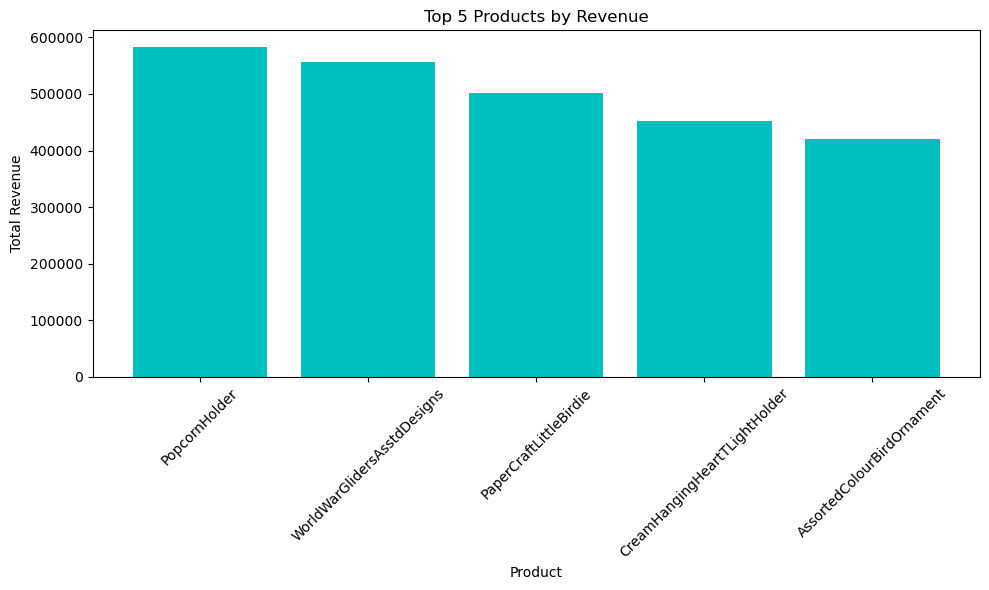

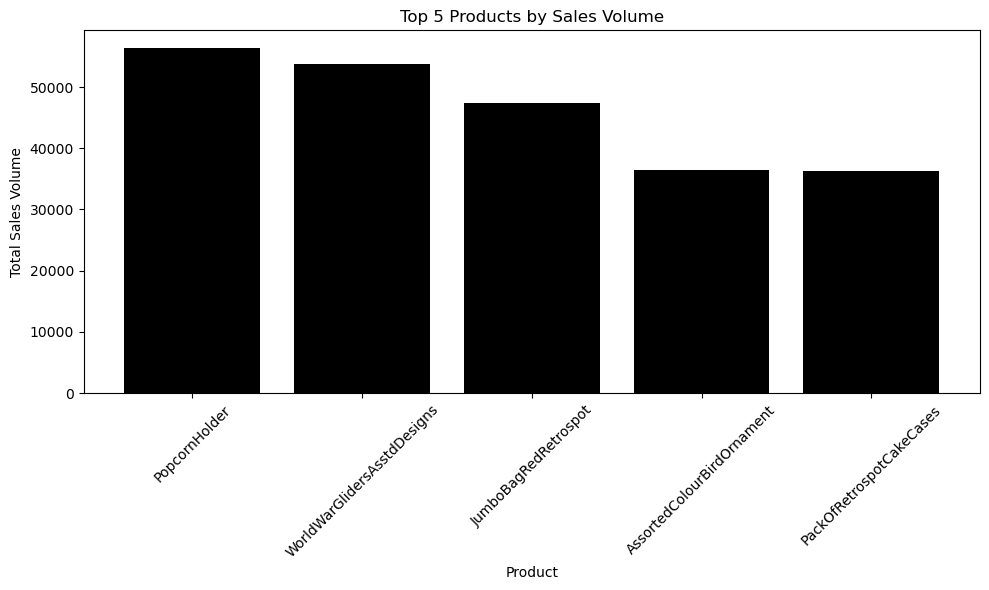

In [10]:
#1.3.3: Top 5 products by revenue in general
top_5_products_by_revenue = df_pandas.groupby('productName_process')['revenue'].sum().nlargest(5).reset_index()

#Plot top 5 products by revenue
plt.figure(figsize=(10, 6))
plt.bar(top_5_products_by_revenue['productName_process'], top_5_products_by_revenue['revenue'], color='c')
plt.title('Top 5 Products by Revenue')
plt.xlabel('Product')
plt.ylabel('Total Revenue')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#1.3.3: Top 5 products by sales volume in general
df_pandas['Quantity'] = df_pandas['Quantity'].astype(int)
top_5_products_by_volume = df_pandas.groupby('productName_process')['Quantity'].sum().nlargest(5).reset_index()

#Plot top 5 products by sales volume
plt.figure(figsize=(10, 6))
plt.bar(top_5_products_by_volume['productName_process'], top_5_products_by_volume['Quantity'], color='black')
plt.title('Top 5 Products by Sales Volume')
plt.xlabel('Product')
plt.ylabel('Total Sales Volume')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Question 1.4

In [12]:
#Group by Country and calculate total revenue
revenue_by_country = df_pandas.groupby('Country')['revenue'].sum().reset_index()
#Find the country with the highest revenue
top_country = revenue_by_country.loc[revenue_by_country['revenue'].idxmax()]
print(f"The country with the highest revenue is: {top_country['Country']}, with total revenue: {top_country['revenue']}")
#Filter data for the top country
top_country_data = df_pandas[df_pandas['Country'] == top_country['Country']]

#Add a month column for transaction date
top_country_data['month'] = top_country_data['transaction_date'].dt.month
#Group by month and calculate total revenue
monthly_revenue = top_country_data.groupby('month')['revenue'].sum().reset_index()
#Identify the month with the highest revenue
top_month = monthly_revenue.loc[monthly_revenue['revenue'].idxmax()]
month_mapping = {
    0: 'January', 1: 'February', 2: 'March', 3: 'April',
    4: 'May', 5: 'June', 6: 'July', 7: 'August',
    8: 'September', 9: 'October', 10: 'November', 11: 'December'
}
#Get the month number and corresponding name
month_number = int(top_month['month'])  # Convert to int for mapping
month_name = month_mapping[month_number]  # Get month name from mapping
#Display the month with the highest revenue
print(f"In {top_country['Country']}, the month with the highest revenue is {month_name}, with total revenue: {top_month['revenue']}.")

The country with the highest revenue is: United Kingdom, with total revenue: 49994032.0
In United Kingdom, the month with the highest revenue is December, with total revenue: 6737640.0.


/var/folders/y8/lzjj81hn3r1bgm__n89fz6zh0000gn/T/ipykernel_80037/2684599108.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_country_data['month'] = top_country_data['transaction_date'].dt.month


Question 1.5

In [11]:
#1.5
start_time = time.time()
#Filter out transactions with Quantity <= 0
filtered_df = df_pandas[df_pandas['Quantity'] > 0]
#Group by CustomerNo and count distinct transactionNo
shopping_frequency = filtered_df.groupby('CustomerNo')['TransactionNo'].nunique().reset_index()
#Find the customer with the highest shopping frequency
most_frequent_shopper = shopping_frequency.loc[shopping_frequency['TransactionNo'].idxmax()]
print(f"The customer with the highest shopping frequency is: {most_frequent_shopper['CustomerNo']} "
      f"with {most_frequent_shopper['TransactionNo']} distinct transactions.")
#Analyze products purchased by this customer
customer_data = filtered_df[ffiltered_df['CustomerNo'] == most_frequent_shopper['CustomerNo']]
#Group by productName_process and sum the quantities
product_analysis = customer_data.groupby('productName_process')['Quantity'].sum().reset_index()
#Sort by Quantity to find the most purchased products
top_products = product_analysis.sort_values(by='Quantity', ascending=False)
#Display the results
print("Products typically purchased by this customer:")
print(top_products)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"\nTime taken to execute the code: {elapsed_time} seconds")

The customer with the highest shopping frequency is: 12748 with 207 distinct transactions.
Products typically purchased by this customer:
                productName_process  Quantity
1609   VictorianMetalPostcardSpring       595
1706    WorldWarGlidersAsstdDesigns       480
1273  RoseScentCandleJewelledDrawer       408
201         CartoonPencilSharpeners       405
1483    SmallWhiteRetrospotMugInBox       390
...                             ...       ...
989                PantryAppleCorer         1
507           FrenchCarriageLantern         1
508       FrenchChateauLargePlatter         1
986    PairOfPinkFlowerClusterSlide         1
1749      dVintageChristmasStickers         1

[1750 rows x 2 columns]

Time taken to execute the code: 0.609915018081665 seconds


In [13]:
start_time = time.time()
#Filter out transactions with Quantity <= 0
filtered_data = sdf.filter(sdf.Quantity > 0)
# Group by CustomerNo and count distinct TransactionNo
shopping_frequency = filtered_data.groupBy('CustomerNo').agg(F.countDistinct('TransactionNo').alias('shopping_frequency'))
# Find the customer with the highest shopping frequency
most_frequent_shopper = shopping_frequency.orderBy(F.desc('shopping_frequency')).first()
print(f"The customer with the highest shopping frequency is: {most_frequent_shopper['CustomerNo']} "
      f"with {most_frequent_shopper['shopping_frequency']} distinct transactions.")
#Analyze products purchased by this customer
customer_data = filtered_data.filter(filtered_data.CustomerNo == most_frequent_shopper['CustomerNo'])
#Group by productName_process and sum the quantities
product_analysis = customer_data.groupBy('productName_process').agg(F.sum('Quantity').alias('total_quantity'))
#Sort by Quantity to find the most purchased products
top_products = product_analysis.orderBy(F.desc('total_quantity'))
#Display the results
print("Products typically purchased by this customer:")
top_products.show()

end_time = time.time()
elapsed_time = end_time - start_time

print(f"\nTime taken to execute the code: {elapsed_time} seconds")

The customer with the highest shopping frequency is: 12748 with 207 distinct transactions.
Products typically purchased by this customer:


+--------------------+--------------+
| productName_process|total_quantity|
+--------------------+--------------+
|VictorianMetalPos...|         595.0|
|WorldWarGlidersAs...|         480.0|
|RoseScentCandleJe...|         408.0|
|CartoonPencilShar...|         405.0|
|SmallWhiteRetrosp...|         390.0|
|VanillaScentCandl...|         380.0|
|SmallRedRetrospot...|         372.0|
|BubblegumRingAsso...|         318.0|
|PopartWoodenPenci...|         300.0|
|OceanScentCandleI...|         225.0|
|AssortedCreepyCra...|         216.0|
|PensAssortedFunny...|         216.0|
|        GarageKeyFob|         174.0|
|MarieAntoinetteTr...|         168.0|
|          KeyFobShed|         164.0|
|    BrocadeRingPurse|         158.0|
|WrapChristmasScre...|         150.0|
|       PopcornHolder|         147.0|
|JazzHeartsPurseNo...|         147.0|
|IvoryChandelierTL...|         144.0|
+--------------------+--------------+
only showing top 20 rows


Time taken to execute the code: 10.603622198104858 seconds


Question 1.6

In [14]:
#1.6.1
#Group by transactionNo and aggregate product_category and productName_process
basket_analysis = filtered_df.groupby('TransactionNo').agg({
    'Product_category': lambda x: list(x),
    'productName_process': lambda x: list(x)
}).reset_index()

#1.6.2
#Function to remove adjacent duplicates
def remove_adjacent_duplicates(lst):
    if not lst:
        return lst
    new_lst = [lst[0]]
    for item in lst[1:]:
        if item != new_lst[-1]:
            new_lst.append(item)
    return new_lst
# Apply the function to both columns
basket_analysis['Product_category'] = basket_analysis['Product_category'].apply(remove_adjacent_duplicates)
basket_analysis['productName_process'] = basket_analysis['productName_process'].apply(remove_adjacent_duplicates)
#Save the processed DataFrame as df_1
df_1 = basket_analysis
#Print the top 10 rows of the processed DataFrame
print(df_1.head(10))


  TransactionNo Product_category  \
0        536365            [0ca]   
1        536366            [0ca]   
2        536367            [0ca]   
3        536368            [0ca]   
4        536369            [0ca]   
5        536370            [0ca]   
6        536371            [0ca]   
7        536372            [0ca]   
8        536373            [0ca]   
9        536374            [0ca]   

                                 productName_process  
0  [CreamHangingHeartTLightHolder, WhiteMoroccanM...  
1      [HandWarmerUnionJack, HandWarmerRedRetrospot]  
2  [AssortedColourBirdOrnament, PoppysPlayhouseBe...  
3  [JamMakingSetWithJars, RedCoatRackParisFashion...  
4                            [BathBuildingBlockWord]  
5  [AlarmClockBakelikePink, AlarmClockBakelikeRed...  
6                          [PaperChainKitSChristmas]  
7      [HandWarmerRedRetrospot, HandWarmerUnionJack]  
8  [CreamHangingHeartTLightHolder, WhiteMoroccanM...  
9                          [VictorianSewingBoxLarge] 

Question 1.7

In [15]:
#1.7.1
#Create new column prod_len
df_1['prod_len'] = df_1['Product_category'].apply(len)
# Print the first five rows of df_1
print("First five rows of df_1:")
print(df_1.head(5))

#1.7.2
# Function to transform product_category into path format
def create_path(product_list):
    return "start > " + " > ".join(product_list) + " > conversion"
#Transform the list in product_category
df_1['path'] = df_1['Product_category'].apply(create_path)

#Define the data_processing function
def data_processing(df, maxlength=3, minlength=1):
    # Filter based on prod_len
    df_filtered = df[(df['prod_len'] <= maxlength) & (df['prod_len'] >= minlength)]
    return df_filtered

#Run the data_processing function with df_1
df_2 = data_processing(df_1, maxlength=5, minlength=2)
#Print the top 10 rows of df_2
print("Top 10 rows of df_2:")
print(df_2.head(10))


First five rows of df_1:
  TransactionNo Product_category  \
0        536365            [0ca]   
1        536366            [0ca]   
2        536367            [0ca]   
3        536368            [0ca]   
4        536369            [0ca]   

                                 productName_process  prod_len  
0  [CreamHangingHeartTLightHolder, WhiteMoroccanM...         1  
1      [HandWarmerUnionJack, HandWarmerRedRetrospot]         1  
2  [AssortedColourBirdOrnament, PoppysPlayhouseBe...         1  
3  [JamMakingSetWithJars, RedCoatRackParisFashion...         1  
4                            [BathBuildingBlockWord]         1  
Top 10 rows of df_2:
   TransactionNo           Product_category  \
13        536378            [0ca, 1ca, 0ca]   
27        536395            [0ca, 1ca, 0ca]   
36        536404  [0ca, 1ca, 0ca, 4ca, 0ca]   
40        536408            [0ca, 1ca, 0ca]   
42        536412            [0ca, 4ca, 0ca]   
43        536415            [0ca, 1ca, 0ca]   
52        536464  

Question 1.8

In [16]:
#Count transactions ending with specific patterns
patterns_end = ['0ca > conversion', '1ca > conversion', '2ca > conversion', 
                '3ca > conversion', '4ca > conversion']
results_end = {pattern: df_2['path'].str.endswith(pattern).sum() for pattern in patterns_end}
#Print results 
print("Transactions ending with specific patterns:")
for pattern, count in results_end.items():
    print(f"{pattern}: {count}")

#Count occurrences of specific patterns in transactions
patterns_contains = ['0ca > 0ca', '0ca > 1ca', '0ca > 2ca', 
                     '0ca > 3ca', '0ca > 4ca', '0ca > conversion']
results_contains = {pattern: df_2['path'].str.count(pattern).sum() for pattern in patterns_contains}
#Print results 
print("\nOccurrences of specific patterns in transactions:")
for pattern, count in results_contains.items():
    print(f"{pattern}: {count}")

#Count occurrences of '... > 0ca > ...'
count_0ca = df_2['path'].str.count(' > 0ca > ').sum()
#Print result 
print(f"\nTotal occurrences of '... > 0ca > ...': {count_0ca}")

#Calculate final result
final_result = sum(results_contains.values()) / count_0ca if count_0ca != 0 else 0
print(f"\nFinal result (sum of counts from 1.8.2 divided by count from 1.8.3): {final_result}")


Transactions ending with specific patterns:
0ca > conversion: 3056
1ca > conversion: 26
2ca > conversion: 144
3ca > conversion: 68
4ca > conversion: 198

Occurrences of specific patterns in transactions:
0ca > 0ca: 0
0ca > 1ca: 1222
0ca > 2ca: 1137
0ca > 3ca: 343
0ca > 4ca: 1198
0ca > conversion: 3056

Total occurrences of '... > 0ca > ...': 6956

Final result (sum of counts from 1.8.2 divided by count from 1.8.3): 1.0


Question 1.9

In [29]:
#1.9.1
#Get the top 100 products by total quantity
top_products = filtered_df.groupby('productName_process')['Quantity'].sum().nlargest(100).index
filtered_df = filtered_df[filtered_df['productName_process'].isin(top_products)]

#Create a transaction-level DataFrame using pivot
transaction_df = filtered_df.pivot_table(index='TransactionNo', 
                                          columns='productName_process', 
                                          values='Quantity', 
                                          fill_value=0)
#1.9.2
#Run the Apriori Algorithm with minimum support of 1.5%
# Convert to boolean DataFrame (1s and 0s for presence/absence)
basket = (transaction_df > 0).astype(int)
frequent_items = apriori(basket, min_support=0.015, use_colnames=True)
# Print the frequent items
print("Frequent items with minimum support of 1.5%:")
print(frequent_items)

#1.9.3
#Run Apriori with support >= 1.0% and lift > 10
frequent_items_high_lift = apriori(basket, min_support=0.01, use_colnames=True)
rules = association_rules(frequent_items_high_lift, metric="lift", min_threshold=10)
#Print the rules
print("\nRules with support >= 1.0% and lift > 10:")
print(rules)

#1.9.4
# Explore additional rules with different metrics
# Example 1: Support >= 0.05 and confidence > 0.6
frequent_items_high_support = apriori(basket, min_support=0.05, use_colnames=True)
rules = association_rules(frequent_items_high_support, metric="confidence", min_threshold=0.6)
#Print the rules
print("\nRules with support >= 5.0% and confidence>0.6:")
print(rules)

# Example 2: Support >= 0.01 and confidence > 0.6 and lift > 10
rules_conf_0_6 = association_rules(frequent_items_high_lift, metric="confidence", min_threshold=0.6)
print("\nRules with support >= 0.01 and confidence > 0.6:")
print(rules_conf_0_6)

# Example 3: 
# Filter rules based on multiple metrics lift > 5, support > 1.5, confidence > 0.6
interesting_rules = rules_conf_0_6[(rules_conf_0_6['lift'] > 5) & (rules_conf_0_6['support'] > 0.015)]
# Display the interesting rules
print("Interesting rules based on combined metrics (lift > 5, support > 0.015, confidence > 0.6):")
print(interesting_rules)

/Users/jasper/Desktop/anaconda3/lib/python3.11/site-packages/mlxtend/frequent_patterns/fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


Frequent items with minimum support of 1.5%:
      support                                           itemsets
0    0.021994                      (AgedGlassSilverTLightHolder)
1    0.058542                         (AntiqueSilverTLightGlass)
2    0.094249                       (AssortedColourBirdOrnament)
3    0.033508                           (AssortedColoursSilkFan)
4    0.036872                                (BaggSwirlyMarbles)
..        ...                                                ...
516  0.016236  (RedRetrospotCharlotteBag, CharlotteBagPinkPol...
517  0.015654  (StrawberryCharlotteBag, RedRetrospotCharlotte...
518  0.016819  (StrawberryCharlotteBag, RedRetrospotCharlotte...
519  0.015137  (JumboBagPinkPolkadot, JumboStorageBagSuki, Ju...
520  0.017336  (JumboBagPinkPolkadot, JumboStorageBagSuki, Ju...

[521 rows x 2 columns]


/Users/jasper/Desktop/anaconda3/lib/python3.11/site-packages/mlxtend/frequent_patterns/fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(



Rules with support >= 1.0% and lift > 10:
                                     antecedents  \
0                     (RedRetrospotCharlotteBag)   
1                     (CharlotteBagPinkPolkadot)   
2                       (StrawberryCharlotteBag)   
3                     (CharlotteBagPinkPolkadot)   
4                       (StrawberryCharlotteBag)   
...                                          ...   
1569    (LunchBagRedRetrospot, LunchBagCarsBlue)   
1570  (LunchBagRedRetrospot, LunchBagBlackSkull)   
1571      (LunchBagSukiDesign, LunchBagCarsBlue)   
1572    (LunchBagSukiDesign, LunchBagBlackSkull)   
1573      (LunchBagCarsBlue, LunchBagBlackSkull)   

                                            consequents  antecedent support  \
0                            (CharlotteBagPinkPolkadot)            0.066887   
1                            (RedRetrospotCharlotteBag)            0.048063   
2                            (CharlotteBagPinkPolkadot)            0.046704   
3               

/Users/jasper/Desktop/anaconda3/lib/python3.11/site-packages/mlxtend/frequent_patterns/fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


Question 1.10

In [31]:
#1.10.1
#Aggregate quantities by CustomerNo and productName_process
customer_product_df = filtered_df.groupby(['CustomerNo', 'productName_process'])['Quantity'].sum().reset_index()
#Pivot the dataframe to get CustomerNo as rows, productName_process as columns
pivot_customer_product_df = customer_product_df.pivot_table(index='CustomerNo', 
                                                            columns='productName_process', 
                                                            values='Quantity', 
                                                            fill_value=0)
#Keep only the top 100 products by total quantity
top_100_products = filtered_df.groupby('productName_process')['Quantity'].sum().nlargest(100).index
pivot_customer_product_df = pivot_customer_product_df[top_100_products]

#1.10.2
# Calculate the pairwise Euclidean distance between customers
pairwise_distances = euclidean_distances(pivot_customer_product_df)

#Convert to DataFrame for easier interpretation
distance_df = pd.DataFrame(pairwise_distances, index=pivot_customer_product_df.index, columns=pivot_customer_product_df.index)
#Ensure CustomerNo is an integer 
pivot_customer_product_df.index = pivot_customer_product_df.index.astype(int)
distance_df.index = distance_df.index.astype(int)  

#1.10.3
#Find the top 3 most similar customers to CustomerNo 13069
similar_to_13069 = distance_df.loc[13069].nsmallest(4).index[1:4]  # Exclude self-distance

#Find the top 3 most similar customers to CustomerNo 17490
similar_to_17490 = distance_df.loc[17490].nsmallest(4).index[1:4]  # Exclude self-distance

print(f"Top 3 most similar customers to CustomerNo 13069: {similar_to_13069}")
print(f"Top 3 most similar customers to CustomerNo 17490: {similar_to_17490}")


Top 3 most similar customers to CustomerNo 13069: Index(['15118', '17523', '18179'], dtype='object', name='CustomerNo')
Top 3 most similar customers to CustomerNo 17490: Index(['12519', '12582', '12652'], dtype='object', name='CustomerNo')
